#📌 Extracción

In [22]:
"""
Importación de librerías
"""
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import numpy as np

In [23]:
"""
Cargar los datos directamente desde la API
"""
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"
response = requests.get(url)
response.raise_for_status()
data_json = response.json()
df_raw = pd.DataFrame(data_json)
# Normalización
df = pd.json_normalize(df_raw.to_dict(orient = "records"))

In [24]:
"""
Cargar los datos desde la carpeta "archivos_base"
"""
path = "./archivos_base/TelecomX_Data.json"
data_json = pd.read_json(path)
df_raw = pd.DataFrame(data_json)
# Normalización
df = pd.json_normalize(df_raw.to_dict(orient = "records"))

#🔧 Transformación

In [25]:
"""
Comprensión del dataset y selección de variables relevantes
"""
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


Considerando que el fin del análisis es determinar las principales **causas de cancelaciones y pérdida de clientes**, se opta por trabajar los datos con aquellos clientes que han decidido dejar la empresa ("Churn": Yes).

In [26]:
"""
Verificación de calidad de datos
"""
# Valores únicos y categorías
print(df["Churn"].value_counts(dropna=False))
# Valores ausentes
print(df.isna().sum())
# Valores duplicados
print(df.duplicated().sum()) 
print(df["customerID"].duplicated().sum())

Churn
No     5174
Yes    1869
        224
Name: count, dtype: int64
customerID                   0
Churn                        0
customer.gender              0
customer.SeniorCitizen       0
customer.Partner             0
customer.Dependents          0
customer.tenure              0
phone.PhoneService           0
phone.MultipleLines          0
internet.InternetService     0
internet.OnlineSecurity      0
internet.OnlineBackup        0
internet.DeviceProtection    0
internet.TechSupport         0
internet.StreamingTV         0
internet.StreamingMovies     0
account.Contract             0
account.PaperlessBilling     0
account.PaymentMethod        0
account.Charges.Monthly      0
account.Charges.Total        0
dtype: int64
0
0


In [27]:
"""
Corrección y limpieza de datos
"""
df_clean = df.copy()
# Churn: valores vacíos
df_clean["Churn"] = df_clean["Churn"].replace("", "Unknown")
# Eliminar "Churn" desconocido para análisis de evasión
df_clean = df_clean[df_clean["Churn"].isin(["Yes", "No"])]
# Limpiar Strings
for col in df_clean.select_dtypes(include = "object").columns:
    df_clean[col] = df_clean[col].str.strip()
#  TotalCharges a numérico
df_clean["account.Charges.Total"] = pd.to_numeric(
    df_clean["account.Charges.Total"], errors = "coerce"
)
df_clean["account.Charges.Total"].fillna(
    df_clean["account.Charges.Total"].median(), inplace = True
)
# Eliminar duplicados por cliente
df_clean.drop_duplicates(subset="customerID", inplace = True)

Se realizó una verificación de calidad de datos identificando valores ausentes, vacíos y/o duplicados. Tras las correcciones necesarias, el dataset se considera apto para las siguientes etapas de análisis.

In [28]:
"""
Creación de la columna 'Cuentas_Diarias'
"""
df_clean["Cuentas_Diarias"] = df_clean["account.Charges.Monthly"] / 30

In [29]:
"""
Estandarización y transformación
"""
# Conversión binaria de "Churn"
df_clean["Churn_bin"] = df_clean["Churn"].map({"No":0, "Yes":1})
# Conversión de variables binarias
binary_cols = [
    "customer.Partner",
    "customer.Dependents",
    "phone.PhoneService",
    "account.PaperlessBilling"
]
for col in binary_cols:
    df_clean[col] = df_clean[col].map({"No":0, "Yes":1})
# Renombrar columnas
df_clean.rename(columns = {
    "account.Charges.Monthly": "Cargos_Mensuales",
    "account.Charges.Total": "Cargos_Totales",
    "account.Contract": "Tipo_Contrato",
    "account.PaymentMethod": "Metodo_Pago"
}, inplace = True)

#📊 Carga y análisis

In [30]:
"""
Análisis descriptivo
"""
print(df_clean.describe())
print(df_clean.describe(include="object"))

       customer.SeniorCitizen  customer.Partner  customer.Dependents  \
count             7043.000000       7043.000000          7043.000000   
mean                 0.162147          0.483033             0.299588   
std                  0.368612          0.499748             0.458110   
min                  0.000000          0.000000             0.000000   
25%                  0.000000          0.000000             0.000000   
50%                  0.000000          0.000000             0.000000   
75%                  0.000000          1.000000             1.000000   
max                  1.000000          1.000000             1.000000   

       customer.tenure  phone.PhoneService  account.PaperlessBilling  \
count      7043.000000         7043.000000               7043.000000   
mean         32.371149            0.903166                  0.592219   
std          24.559481            0.295752                  0.491457   
min           0.000000            0.000000                  0.0

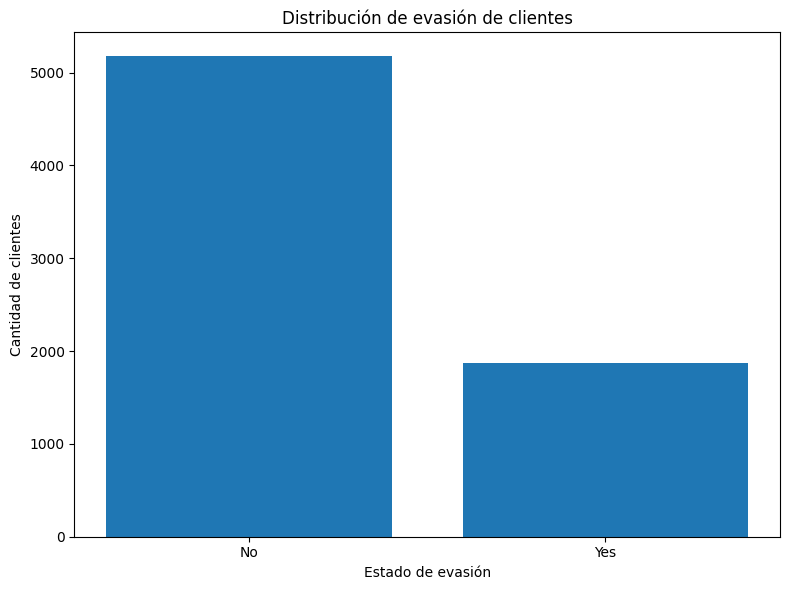

In [31]:
"""
Distribución de evasión
"""
churn_counts = df_clean["Churn"].value_counts()
# Crear gráfico
plt.figure(figsize=(8,6))
plt.bar(churn_counts.index, churn_counts.values)
plt.title("Distribución de evasión de clientes")
plt.xlabel("Estado de evasión")
plt.ylabel("Cantidad de clientes")
plt.tight_layout()
plt.show()


La distribución de la variable "Churn" muestra que los clientes que permanecieron en la empresa superan ampliamente a los que se fueron. Para este análisis se consideraron únicamente los valores válidos (‘Yes’ y ‘No’), excluyendo registros con información faltante.

In [32]:
"""
Recuento de evasión por variables categóricas
"""
def churn_by_category(df, category_col):
    churn_rate = (
        df.groupby(category_col)["Churn_bin"]
          .mean()
          .sort_values(ascending=False)
    )
    
    plt.figure(figsize=(9, 6))
    churn_rate.plot(kind="bar")
    plt.title(f"Tasa de evasión según {category_col}")
    plt.xlabel(category_col)
    plt.ylabel("Tasa de evasión")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    
    return churn_rate

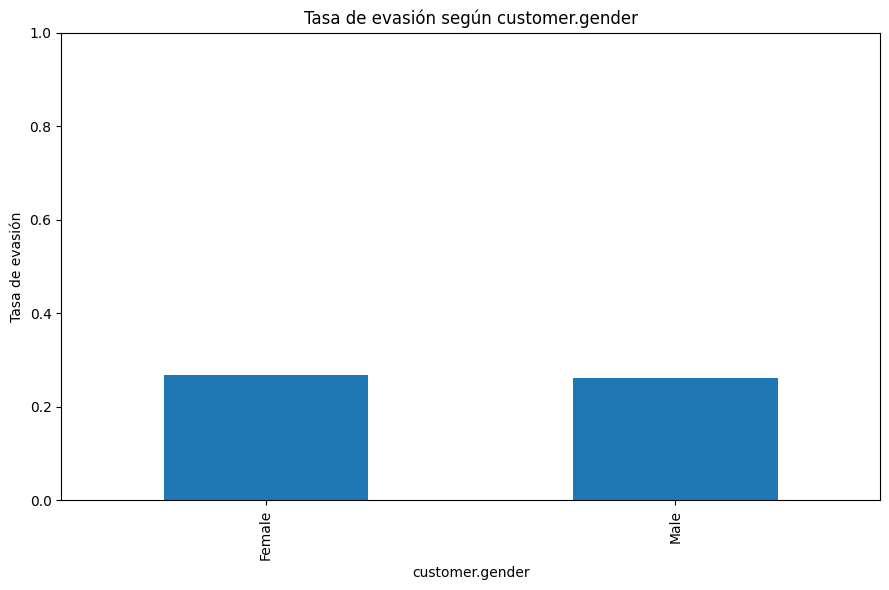

customer.gender
Female    0.269209
Male      0.261603
Name: Churn_bin, dtype: float64

In [33]:
### Evación según género
churn_gender = churn_by_category(df_clean, "customer.gender")
churn_gender

No se observan diferencias drásticas entre las personas que decidieron dejar la empresa en cuanto al sexo (Femenino y Masculino).

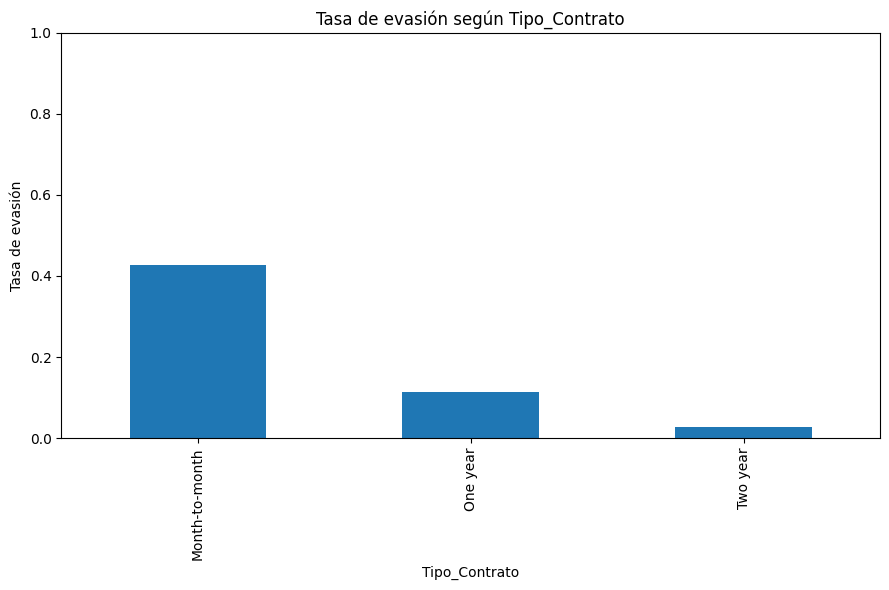

Tipo_Contrato
Month-to-month    0.427097
One year          0.112695
Two year          0.028319
Name: Churn_bin, dtype: float64

In [34]:
# Evasión seún tipo de contrato
churn_contract = churn_by_category(df_clean, "Tipo_Contrato")
churn_contract

Las cantidad de personas que decidieron abandonar la empresa son aquellas que, principalmente, contaban con un contrato "Mes a mes". Existe una amplia diferencia entre este grupo y aquellas que abandonaron la empresa y cuyo contrato fue de 01 o 02 años.

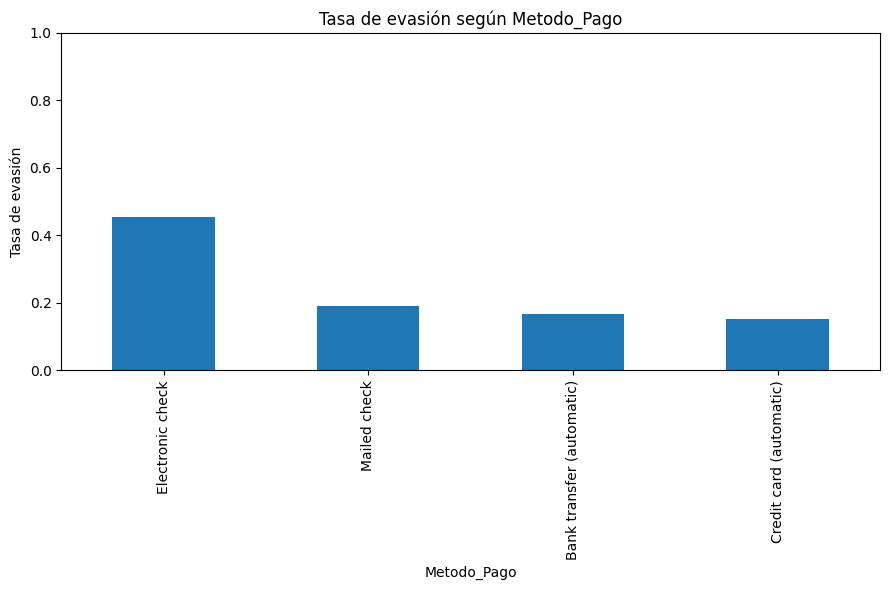

Metodo_Pago
Electronic check             0.452854
Mailed check                 0.191067
Bank transfer (automatic)    0.167098
Credit card (automatic)      0.152431
Name: Churn_bin, dtype: float64

In [35]:
# Evasión según método de pago
churn_payment = churn_by_category(df_clean, "Metodo_Pago")
churn_payment

Se observa que hay una mayor cantidad de personas que abandonaron la empresa cuyo método de pago fue manual.

**Conclusión**: El análisis de la evasión según variables categóricas revela diferencias significativas en la tasa de cancelación entre tipos de contrato y métodos de pago, destacando un mayor churn en contratos mensuales y en clientes que utilizan métodos de pago manuales. En contraste, variables demográficas como el género presentan un impacto limitado en la evasión.

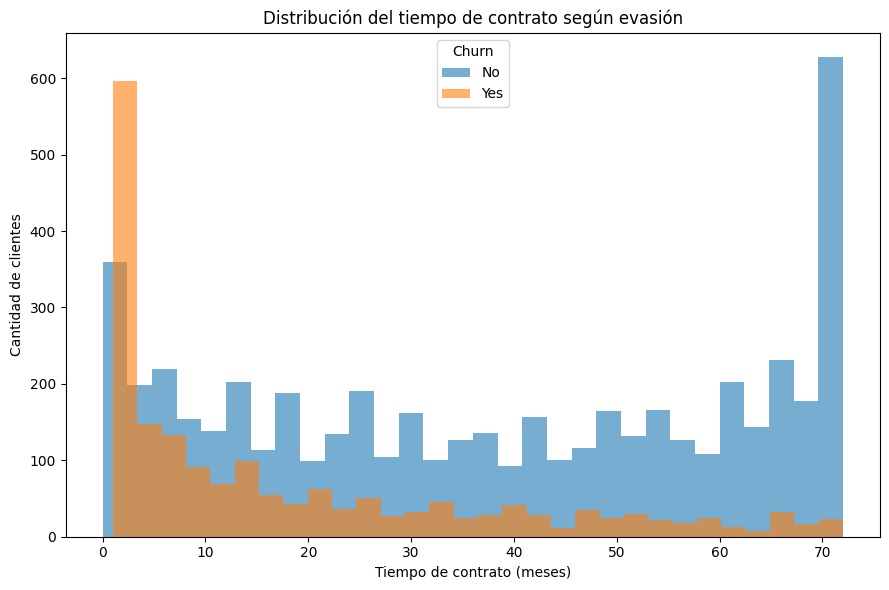

In [36]:
"""
Conteo de evasión por variables numéricas
"""
# Clientes con y sin evasión
churn_yes = df_clean[df_clean["Churn"] == "Yes"]
churn_no  = df_clean[df_clean["Churn"] == "No"]
# Distribución del tiempo de contrato
plt.figure(figsize=(9,6))
plt.hist(churn_no["customer.tenure"], bins=30, alpha=0.6, label="No")
plt.hist(churn_yes["customer.tenure"], bins=30, alpha=0.6, label="Yes")
plt.title("Distribución del tiempo de contrato según evasión")
plt.xlabel("Tiempo de contrato (meses)")
plt.ylabel("Cantidad de clientes")
plt.legend(title="Churn")
plt.tight_layout()
plt.show()


Se obserba, a grandes rasgos que, aquellos clientes más antiguos presentan una menor proporción de abandono de la empresa. Caso contrario ocurre con aquellos clientes que tienen menos tiempo en la empresa.

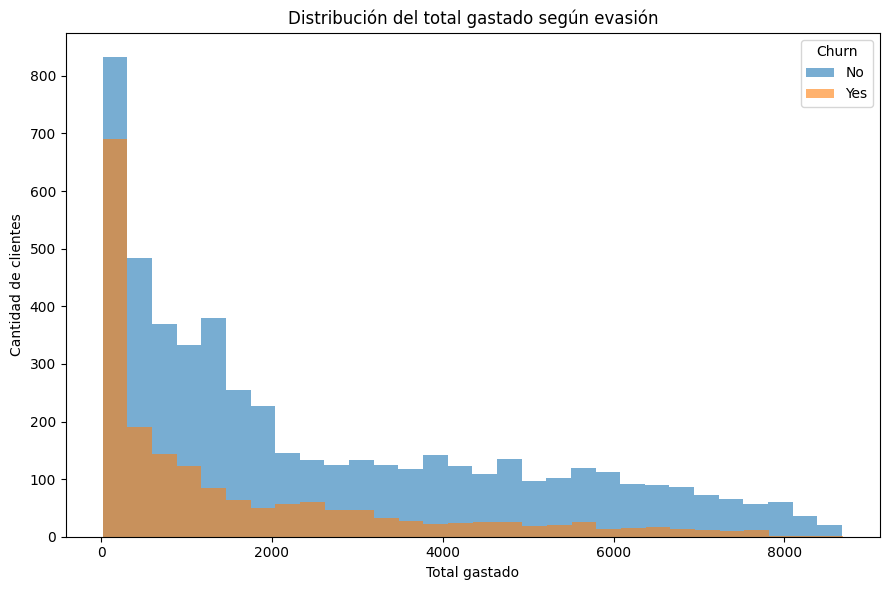

In [37]:
# Distribución de cargos totales
plt.figure(figsize=(9,6))
plt.hist(churn_no["Cargos_Totales"], bins=30, alpha=0.6, label="No")
plt.hist(churn_yes["Cargos_Totales"], bins=30, alpha=0.6, label="Yes")
plt.title("Distribución del total gastado según evasión")
plt.xlabel("Total gastado")
plt.ylabel("Cantidad de clientes")
plt.legend(title="Churn")
plt.tight_layout()
plt.show()

Se observa que aqullos clientes que abandonan la empresa (los que tienen menos tiempo) son los que menos gastan; mientras que los clientes más antiguos tienen un total de gasto mucho mayor. 

C:\Users\aaiza\AppData\Local\Temp\ipykernel_19412\3753705559.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


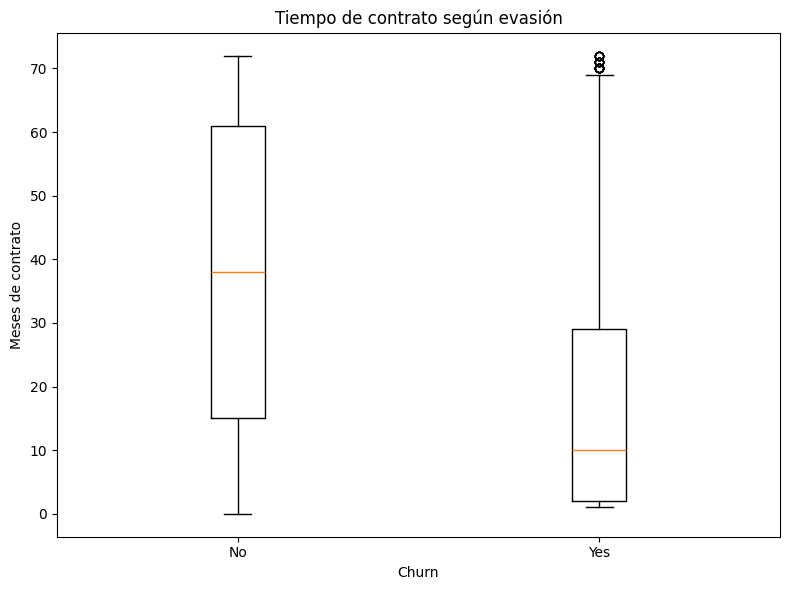

In [38]:
# Tiempo de contrato (boxplot)
plt.figure(figsize=(8,6))
plt.boxplot(
    [churn_no["customer.tenure"], churn_yes["customer.tenure"]],
    labels=["No", "Yes"]
)
plt.title("Tiempo de contrato según evasión")
plt.xlabel("Churn")
plt.ylabel("Meses de contrato")
plt.tight_layout()
plt.show()

C:\Users\aaiza\AppData\Local\Temp\ipykernel_19412\734162871.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


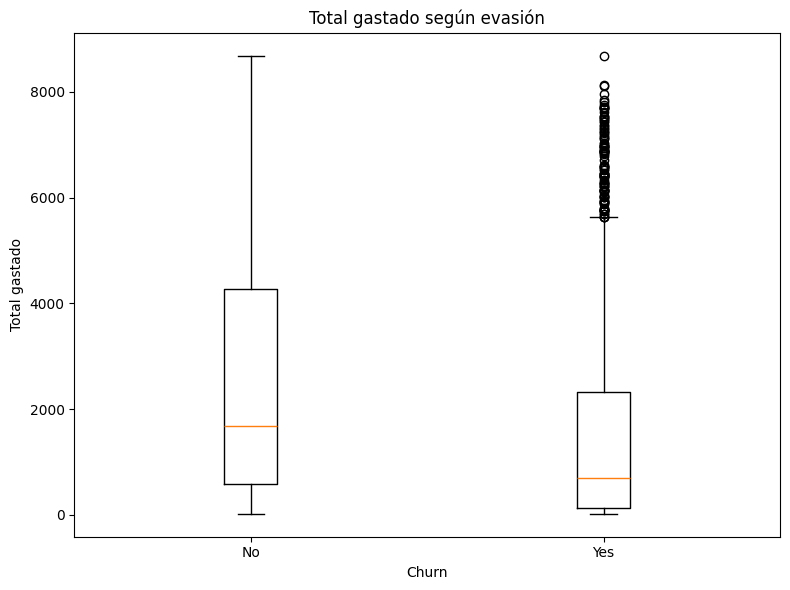

In [39]:
# Total gastado (boxplot)
plt.figure(figsize=(8,6))
plt.boxplot(
    [churn_no["Cargos_Totales"], churn_yes["Cargos_Totales"]],
    labels=["No", "Yes"]
)
plt.title("Total gastado según evasión")
plt.xlabel("Churn")
plt.ylabel("Total gastado")
plt.tight_layout()
plt.show()

C:\Users\aaiza\AppData\Local\Temp\ipykernel_19412\3464280451.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


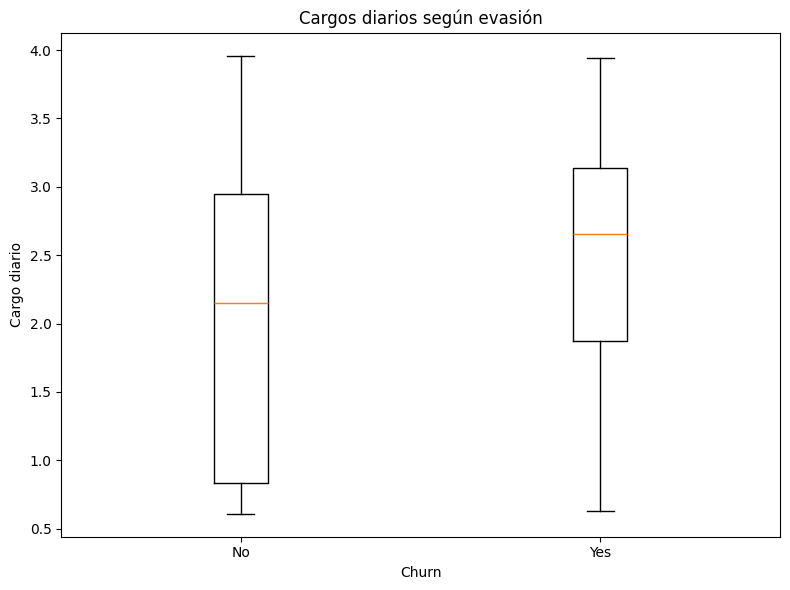

In [40]:
# Análisis con cargos diarios
plt.figure(figsize=(8,6))
plt.boxplot(
    [churn_no["Cuentas_Diarias"], churn_yes["Cuentas_Diarias"]],
    labels=["No", "Yes"]
)
plt.title("Cargos diarios según evasión")
plt.xlabel("Churn")
plt.ylabel("Cargo diario")
plt.tight_layout()
plt.show()

**Conclusión**: El análisis de variables numéricas muestra diferencias claras entre clientes que abandonaron el servicio y aquellos que permanecieron. Los clientes con evasión presentan, en promedio, menor tiempo de contrato y menor gasto total, lo que sugiere que la evasión ocurre principalmente en etapas tempranas de la relación con la empresa. Asimismo, se observan variaciones en los cargos diarios que podrían influir en la percepción de valor del servicio.

In [ ]:
"""
Análisis adicional: correlación entre variables
"""
# Selección de variables
corr_df = df_clean[
    [
        "Churn_bin",
        "Cuentas_Diarias",
        "Cargos_Mensuales",
        "Cargos_Totales",
        "customer.tenure"
    ]
]
# Matriz de correlación
corr_matrix = corr_df.corr()
corr_matrix

,Churn_bin,Cuentas_Diarias,Cargos_Mensuales,Cargos_Totales,customer.tenure
Churn_bin,1.000000,0.193356,0.193356,-0.199037,-0.352229
Cuentas_Diarias,0.193356,1.000000,1.000000,0.650864,0.247900
Cargos_Mensuales,0.193356,1.000000,1.000000,0.650864,0.247900
Cargos_Totales,-0.199037,0.650864,0.650864,1.000000,0.825464
customer.tenure,-0.352229,0.247900,0.247900,0.825464,1.000000


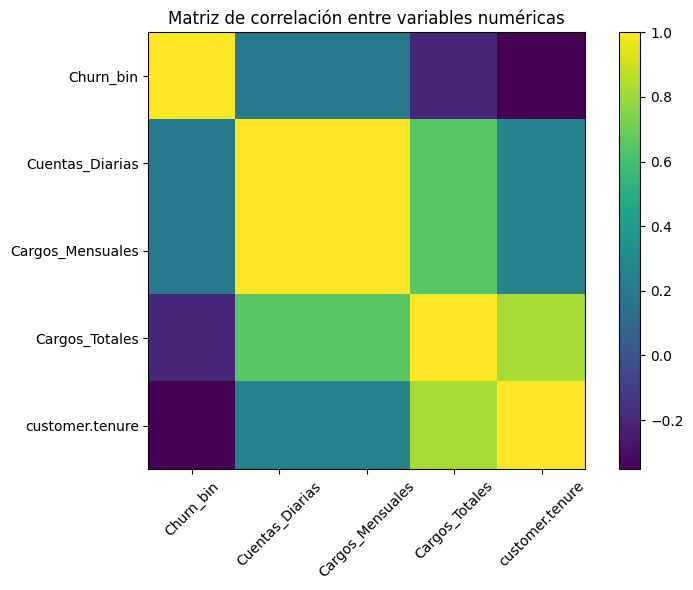

In [47]:
# Gráfica de correlación
plt.figure(figsize=(8,6))
plt.imshow(corr_matrix)
plt.colorbar()
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation = 45)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.title("Matriz de correlación entre variables numéricas")
plt.tight_layout()
plt.show()

#📄Informe final

# 1. Introducción

La evasión de clientes (Churn) representa uno de los principales desafíos para la empresa "Telecom X", pues genera la pérdida directa de ingresos. 

El objetivo de este análisis es identificar patrones y variables asociadas a la evasión de clientes de Telecom X, utilizando técnicas de análisis exploratorio de datos (EDA). A partir de información demográfica, características del servicio contratado y variables de facturación, se busca obtener información que permita orientar acciones estratégicas para reducir el churn.

# 2. Limpieza y tratamiento de datos

Los datos fueron obtenidos directamente desde la fuente oficial de Telecom X en formato JSON mediante una solicitud HTTP. Dado que el archivo presentaba una estructura anidada, fue necesario normalizar los datos para convertirlos en un DataFrame plano de Pandas, facilitando su análisis.

Durante la etapa de limpieza y preparación se realizaron las siguientes acciones:

- Exploración inicial de la estructura del dataset y tipos de datos.
- Identificación de valores ausentes y categorías inconsistentes.
- Tratamiento de valores vacíos en Churn, excluyendo registros con estado desconocido.
- Conversión de variables numéricas mal tipadas, como el total facturado.
- Eliminación de registros duplicados basados en el identificador del cliente.
- Normalización de variables categóricas (eliminación de espacios y estandarización de valores).
- Creación de la variable "Cuentas_Diarias", calculada a partir de la facturación mensual.
- Transformación de variables binarias (Yes/No) a valores numéricos (1/0) para facilitar el análisis.

# 3. Análisis Exploratorio de Datos (EDA)
## Distribución de la evasión

El análisis inicial mostró que el dataset presenta un desbalance moderado entre clientes que permanecieron y clientes que cancelaron el servicio, un comportamiento esperado en problemas de churn.

## Evasión según variables categóricas

### Tipo de contrato: 
Los contratos mensuales (month-to-month) presentan una tasa de evasión significativamente mayor que los contratos de uno o dos años, lo que sugiere que la permanencia contractual reduce el riesgo de churn.

### Método de pago:
Los clientes que utilizan métodos de pago manuales, especialmente "Electronic check", muestran una mayor propensión a cancelar el servicio, mientras que los métodos automáticos presentan menor evasión.

### Variables demográficas:
Factores como el género no muestran diferencias relevantes en la tasa de churn, indicando un impacto limitado en la evasión.

## Evasión según variables numéricas

### Tiempo de contrato (tenure):
Los clientes que abandonan el servicio tienden a tener un tiempo de contrato significativamente menor, lo que indica que la evasión ocurre con mayor frecuencia en etapas tempranas.

### Total gastado:
Los clientes con churn presentan un menor gasto total acumulado, reforzando la idea de abandono temprano.

### Cargos diarios:
Se observan diferencias en los cargos diarios entre ambos grupos, lo que podría influir en la percepción de valor del servicio.


# 4. Conclusiones

- La evasión de clientes ocurre principalmente en clientes nuevos o con baja antigüedad.
- El tipo de contrato es uno de los factores más influyentes en la evasión.
- Los métodos de pago automáticos están asociados con una menor tasa de churn.
- Variables demográficas presentan un impacto limitado en comparación con variables contractuales y financieras.
- El gasto acumulado y la duración de la relación con la empresa son indicadores relevantes del riesgo de evasión.

# 5. Recomendaciones

Con base en los resultados obtenidos, se proponen las siguientes acciones estratégicas para reducir la evasión de clientes:

- Incentivar contratos de mayor duración, ofreciendo beneficios exclusivos para clientes que migren de contratos mensuales a contratos anuales.
- Promover métodos de pago automáticos, mejorando la retención.
- Implementar estrategias de retención temprana, enfocadas en clientes con bajo tiempo de contrato.
